# Math 607 HW 4
### Sean Ericson 6/10/2024

In [1]:
# Imports
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,physics}'
mpl.rcParams["animation.html"] = "jshtml"

%matplotlib inline

## Ising Model

In [24]:
# Code
def neighbor_indices(n, i, j):
    return [(i+x, j+y) for x,y in [(0,1), (0, -1), (1, 0), (-1, 0)] if 0 <= i+x <= n-1 and 0 <= j+y <= n-1]

def neighbor_spins(σ, i, j):
    n = σ.shape[0]
    return [σ[x, y] for x,y in neighbor_indices(n, i, j)]

def Ising_Hamiltonian(σ, J, μ):
    n = σ.shape[0]
    return -J*sum([σ[i//n, i%n] * sum(neighbor_spins(σ, i//n, i%n)) for i in range(n*n)])/2 - μ*σ.sum()

def flip_spin(σ, J, μ, β, site=None):
    """
    Attempt to flip spin at 'site' if given, else a randomly selected site is chosen.
    The spin is flipped with probability min(1, exp(-β*ΔH))
    """
    # Determine n from the shape of σ
    n = σ.shape[0] 
    
    # Determine site 
    i, j = site or np.random.randint(n, size=2)

    # Sum neighbor spins
    neb_sum = sum(neighbor_spins(σ, i, j))
    
    # Calculate the change in energy from flipping spin (i,j)
    ΔH = 2*σ[i,j]*(J*neb_sum + μ)

    # With probability min(1, exp(-β*ΔH)), flip the spin
    if np.random.rand() < np.exp(-β*ΔH):
        σ[i,j] *= -1

def plot_spins(σ, ax):
    ax.axis('off')
    ax.imshow(σ, cmap="Greys", vmin=-1, vmax=1)

In [3]:
# Define sim constants
N = 20
J, μ, β = (1, 1, 1)

# Initialize maximal/minimal elements of the poset.
high = np.ones((N,N))
low = -1*np.ones((N,N))

# Initialize lists to track states
lows = [np.array(low)]
highs = [np.array(high)]

# Initialize lists to track energies
low_Hs = [Ising_Hamiltonian(low, J, μ)]
high_Hs = [Ising_Hamiltonian(high, J, μ)]

# Loop until the min/max elements become equal
while not np.array_equal(low, high):
    # Pick a random site
    site = np.random.randint(N, size=2)

    # Try to flip the same spin on each state
    flip_spin(low, J, μ, β, site)
    flip_spin(high, J, μ, β, site)

    # Record states and energies
    lows.append(np.array(low))
    highs.append(np.array(high))
    low_Hs.append(Ising_Hamiltonian(lows[-1], J, μ))
    high_Hs.append(Ising_Hamiltonian(highs[-1], J, μ))

print("Number of iterations: ", len(lows))

13392


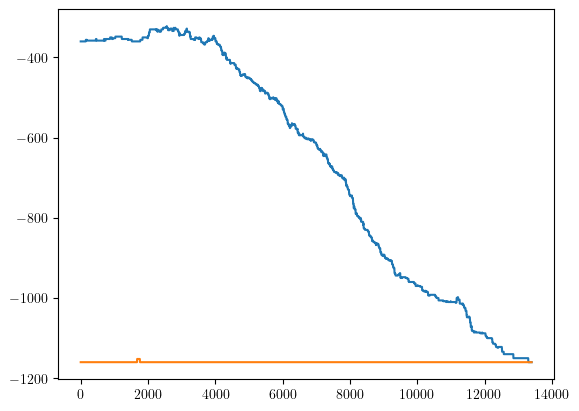

In [4]:
xs = list(range(len(lows)))
plt.plot(xs, low_Hs)
plt.plot(xs, high_Hs)

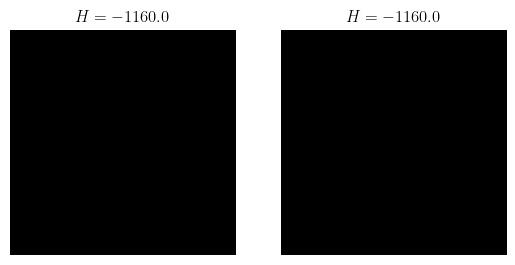

In [5]:
fig, ax = plt.subplots(1, 2)
plot_spins(lows[-1], ax[0])
plot_spins(highs[-1], ax[1])
ax[0].set_title("$H = {}$".format(low_Hs[-1]))
ax[1].set_title("$H = {}$".format(high_Hs[-1]))
plt.show()

In [35]:
fig, ax = plt.subplots(1, 2)
def update(frame):
    plt.cla()
    plot_spins(lows[frame], ax[0])
    plot_spins(highs[frame], ax[1])
    ax[0].set_title("$H = {}$".format(Ising_Hamiltonian(lows[0], J, μ)))
    ax[1].set_title("$H = {}$".format(Ising_Hamiltonian(highs[0], J, μ)))
    
anim = animation.FuncAnimation(fig, update, frames=range(0, len(lows), int(len(lows) / 100)), interval=20)
plt.close()

In [39]:
display(anim)

## Continuous time markov chains

### a)
The markov property
$$ \mathbb{P}(X_{l+1} = j \;|\; X_{l}=i, X_{l-1} = i_{l-1}, \ldots, X_0 = i_0) = \mathbb{P}(X_{t+1} = j\lvert X_{t}=i) $$
for discrete-time Markov chains already implies that
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i, X_{s_0} = i_0, \ldots X_{s_n} = i_n) = \mathbb{P}(X_{t+s} = j \;|\; X_s = i), $$
i.e. it already gives us that the future is independent of the past, conditioned on the present. So, we just need to show that for a continuous-time Markov chain
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i) = \mathbb{P}(X_{t} = j \;|\; X_0 = i). $$
Now, the probability $\mathbb{P}(X_{t+s} = j \;|\; X_s = i)$ depends on the number of transitions in the period $[s, s+t]$, $N([s, s+t])$. This number is distributed as
$$ \text{Poisson}(\mu([s, s+t])) = \text{Poisson}(\lambda(s+t-s)) = \text{Poisson}(\lambda t), $$
and clearly depends only on the length of the interval. Therefore,
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i) = \mathbb{P}(X_{t} = j \;|\; X_0 = i), $$ 
and thus
$$ 
\mathbb{P}(X_{t+s} = j \;|\; X_s = i, X_{s_0} = i_0,  \ldots X_{s_n} = i_n) = \mathbb{P}(X_{t} = j \;|\; X_0 = i).
$$


### b)
The transition probability $p_t(i,j)$ is the probability that we are in state $j$ at time $t$, given that we started in state $i$. This is given by the sum of the probabilities that $k$ jumps take us from $i$ to $j$, weighted by the probability that $k$ jumps occur in time $t$. I.e.
$$ p_t(i,j) = \sum_{k=0}^\infty p_k^t \bra{j}A^k\ket{i},  $$
where
$$ p_k^t \coloneqq \frac{(t\lambda)^k e^{-\lambda t}}{k!}. $$

Then,
$$
\begin{align}
    \sum_{k}p_s(i,k)p_t(k,j) &= \sum_k \sum_{l=0}^\infty p_l^s \bra{k}A^l\ket{i} \sum_{m=0} p_m^t \bra{j}A^m\ket{k} \\
    &= \sum_{klm} p_l^s p_m^t \bra{j}A^l\ket{k}\bra{k}A^m\ket{i} \\
    &= \sum_{klm} p_l^s p_m^t \bra{j}A^{l+m}\ket{i} \\
    &= \bra{j} \left[\sum_{lm} p_l^s A^l p_m^t A^m \right] \ket{i} \\
    &= \bra{j} \left[\sum_{l=0}^\infty\sum_{m=0}^l p_m^s A^m p_{l-m}^t A^{l-m} \right] \ket{i} \\
    &= \sum_{l=0}^\infty\sum_{m=0}^l \frac{(t\lambda)^m e^{-\lambda t}}{m!}\frac{(s\lambda)^{l-m}e^{-\lambda s}}{(l-m)!} \bra{j}A^l\ket{i} \\
    &= \sum_{l=0}^\infty\sum_{m=0}^l \frac{t^m s^{l-m}}{m!(l-m)!} \lambda^l e^{-\lambda(s+t)} \bra{j}A^l\ket{i} \\
    &= \sum_l \frac{((s+t)\lambda)^l e^{-\lambda(s+t)}}{l!} \bra{j}A^l\ket{i} \\
    &= \sum_l p_l^{s+t} \bra{j}A^l\ket{i} \\
    &= p_{s+t}(i,j),
\end{align}
$$
where $\sum_k \ket{k}\bra{k} = \mathbb{I}$ was used in line 3, the Cauchy product was used in line 5, and the binomial expansion was used in line 8.

### c)
$$ 
\begin{align*}
    \mathbf{P}(N([0,h])) > 1 &= 1 - p(0) - p(1) \\
    &= 1 - e^{-\lambda h} - \lambda h e^{-\lambda h} \\
    &= 1 - (1 + \lambda h)e^{-\lambda h} \\
    &\approx 1 - (1 + \lambda h)(1 - \lambda h) \\
    &\approx \lambda^2 h^2
\end{align*}
$$

$$
\begin{align*}
    \frac{\text{d}}{\text{d}h} p_h(i,j)\rvert_{h=0} &= \frac{\text{d}}{\text{d}h} \left(e^{-\lambda h}\sum_l \frac{(\lambda h)^l}{l!}A_{ij}^l\right) \bigg\rvert_{h=0} \\
    &= e^{-\lambda h}\left(\sum_{l=1}^\infty \frac{\lambda^l h^{l-1}}{(l-1)!}A_{ij}^l - \lambda\sum_{l=0}^\infty\frac{(\lambda h)^l}{l!}A_{ij}^l \right)\bigg\rvert_{h=0} \\
    &= e^{-\lambda h}\sum_{l=0}^\infty \frac{\lambda^{l+1}h^l}{l!}\left(A_{ij}^{l+1} - A_{ij}^l\right) \bigg\rvert_{h=0} \\
    &= \lambda\left(A_{ij} - \delta_{ij}\right) \\
    &= \lambda A_{ij} \quad (i \neq j)
\end{align*}
$$

## Simulation of Continuous-Time Random Walk

In [8]:
def simulate_walk(time, λ=1, D=5):
    """
    Simulate a continuous time random walk on the corners of a 'D' dimensional unit-hypercube, starting at the origin.
    Jumps occur at the given rate over the given time. 
    A list of tuples of (times, states) is returned representing the times at which the transitions occurred,
    along with the states that were transitioned to. The first tuple in the list is (0, initial_state)
    """
    state = np.zeros(D)
    step_times = sorted(np.random.uniform(0, time, np.random.poisson(λ*time)))
    states = [(0, np.array(state))]
    for t in step_times:
        n = np.random.randint(D)
        state[n] = 1 - state[n]
        states.append((t, np.array(state)))
    return states


def sample_walk(walk, times):
    """
    Take the output of 'simulate_walk' and return a list of states that correspond the state of the walk at the given times.
    """
    step_times, states = zip(*walk)
    state_samples = []
    for t in times:
        # Determine which transitions occurred after the current time
        latter_step_times = [step_time for step_time in step_times if step_time > t]

        if len(latter_step_times) == 0:
            # if no more steps occurred, use the last state
            state_samples.append(states[-1])
        else:
            # else, use the state immediately before the next step
            next_step_time = latter_step_times[0]
            state_samples.append(states[step_times.index(next_step_time) - 1])

    return state_samples

In [9]:
# Define simulation parameters
total_time = 20
N_time_samples = 200
N_walk_samples = int(1e4)

# Define time samples (for plotting output)
ts = np.linspace(0, total_time, N_time_samples)

# Simulate walks
walks = [simulate_walk(total_time) for _ in range(N_walk_samples)]

# Generate the 'continuous-time' samples
sampled_walks = [sample_walk(walk, ts) for walk in walks]

# Calculate the "rank" (the sum of the entries of the vector) of each state for all walks.
ranks = np.array([[sum(state) for state in walk] for walk in sampled_walks])

# Label the states of each walk
states = np.array([[sum([state[i]*2**i for i in range(5)]) for state in walk] for walk in sampled_walks])

The rank $r$ of a uniformly random state in dimension $n$ is Binomially distributed as 
$$ \text{Bin}(r; n, 1/2) = \begin{pmatrix}n \\ r\end{pmatrix}\left(\frac{1}{2}\right)^n. $$
The expectation value and variance are given by

$$
\begin{align*}
    \mathbb{E}[r] &= \frac{n}{2} \\
    \text{Var}[r] &= \frac{n}{4}
\end{align*}
$$

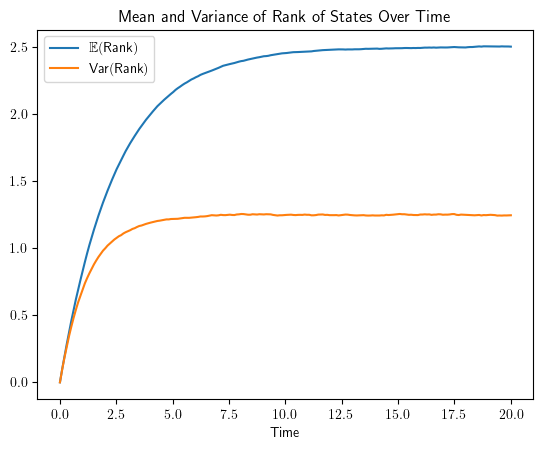

Final mean: 2.504 (relative error: 0.002)
Final var:  1.246 (relative error: -0.003)


In [32]:
means = np.mean(ranks, axis=0)
vars = np.var(ranks, axis=0)
plt.plot(ts, means, label=r"$\mathbb{E}(\text{Rank})$")
plt.plot(ts, vars, label=r"$\text{Var}(\text{Rank})$")
plt.xlabel("Time")
plt.title("Mean and Variance of Rank of States Over Time")
plt.legend()
plt.show()
print("Final mean: {:.3f} (relative error: {:.3f})".format(means[-1], (means[-1] - 2.5)/2.5))
print("Final var:  {:.3f} (relative error: {:.3f})".format(vars[-1], (vars[-1] - 5/4) / (5/4)))

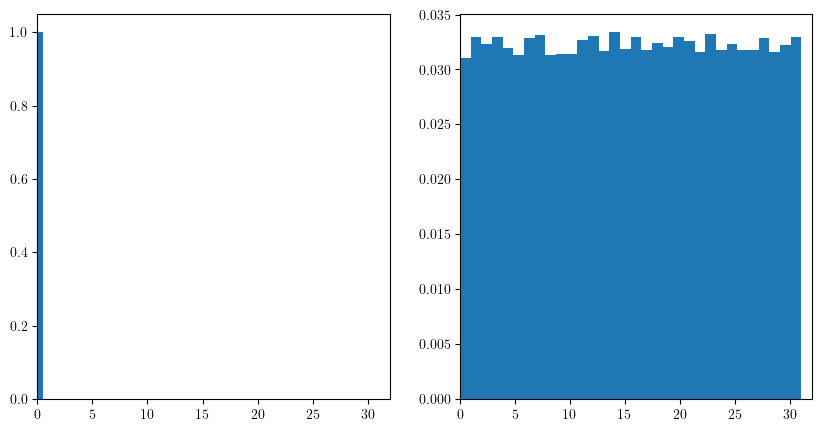

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(states[:, 0], density=True, bins=1)
ax[0].set_xlim(0, 32)
ax[1].hist(states[:, -1], density=True, bins=32)
ax[1].set_xlim(0, 32)
plt.show()

In [37]:
fig, ax = plt.subplots()
def update(frame):
    ax.clear()
    ax.hist(states[:, frame], density=True, bins=32)
    ax.set_xlim(0, 32)
anim = animation.FuncAnimation(fig, update, N_time_samples, interval=20)
plt.close()

In [38]:
display(anim)

## Multivariate Normal Fitting

In [14]:
d = 10
N = int(1e4)
L = np.zeros((d,d))
for i in range(d):
    for j in range(i+1):
        L[i,j] = 1/(i - j + 1)
L = np.array(L)
C = np.dot(L, L.T)
S = scipy.stats.multivariate_normal.rvs(np.zeros(d), C, size=N)

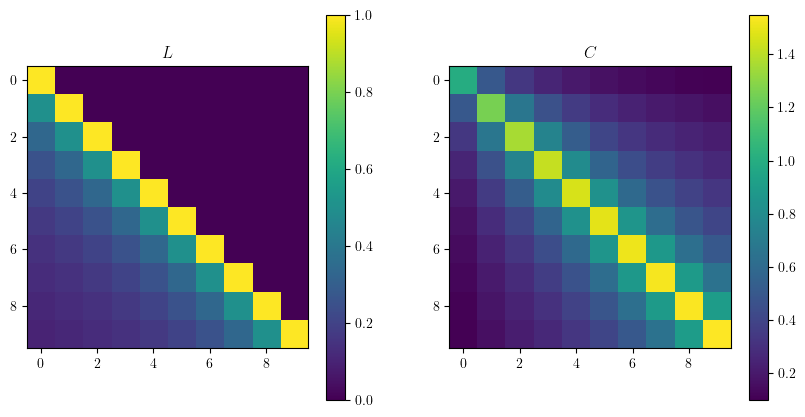

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
data0 = ax[0].imshow(L)
ax[0].set_title("$L$")
data1 = ax[1].imshow(C)
ax[1].set_title("$C$")
fig.colorbar(data0, ax=ax[0])
fig.colorbar(data1, ax=ax[1])
plt.show()

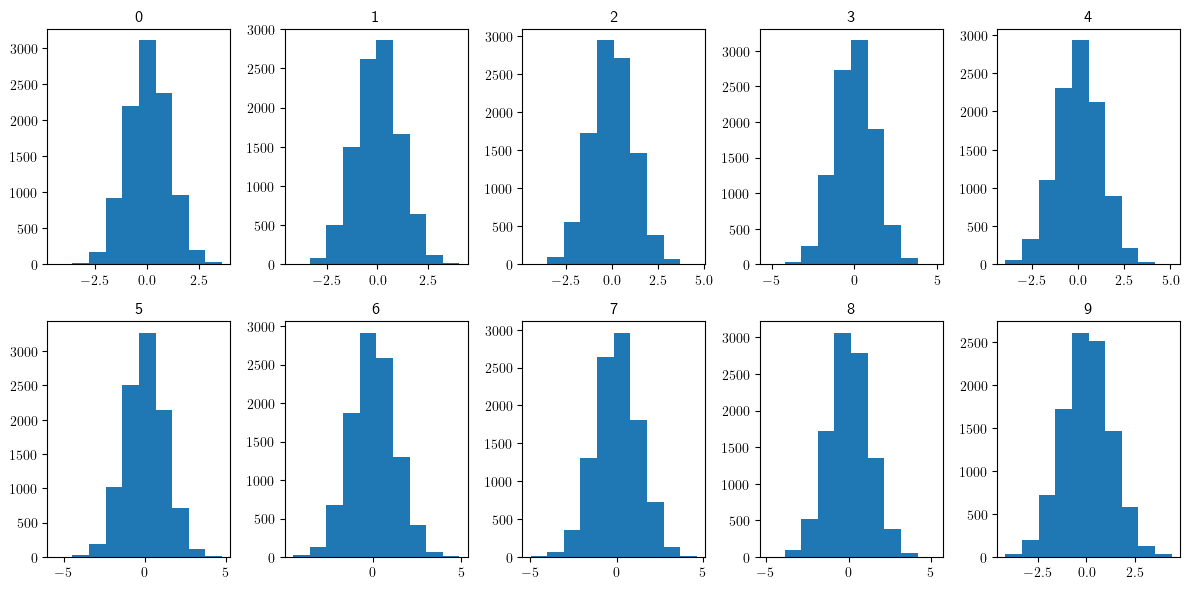

In [42]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    a = ax[i//5][i%5]
    a.hist(S[:,i])
    a.set_title("{}".format(i))
fig.tight_layout()
plt.suptitle("")
plt.show()

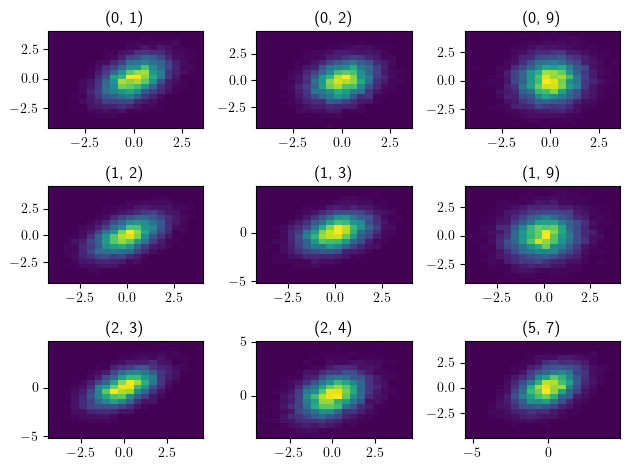

In [43]:
indices = [(0, 1), (0, 2), (0, 9), (1, 2), (1, 3), (1, 9), (2, 3), (2, 4), (5, 7)]
fig, ax = plt.subplots(3, 3)
for n,ind in enumerate(indices):
    a = ax[n//3][n%3]
    i,j = ind
    a.hist2d(S[:,i], S[:,j], bins=(20,20))
    a.set_title("({}, {})".format(i, j))
fig.tight_layout()
plt.show()

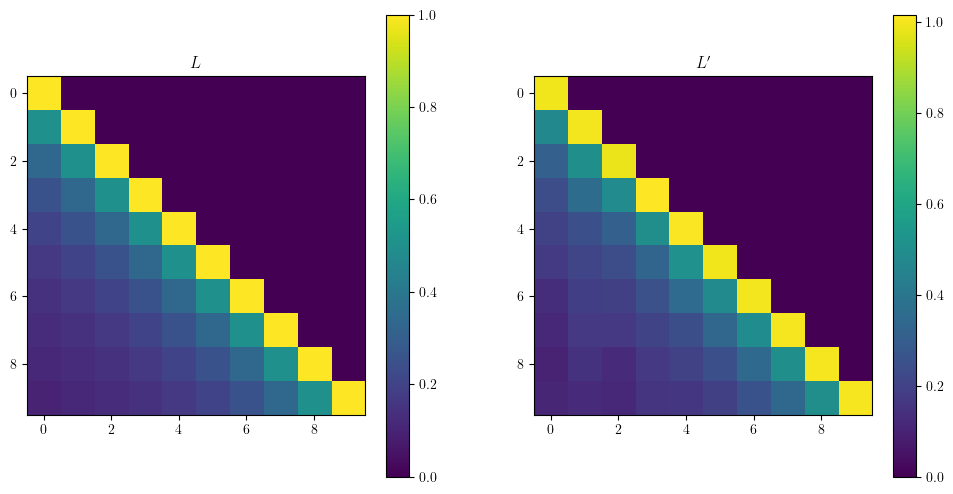

In [18]:
cov = np.cov(S.T)
L_prime = np.linalg.cholesky(cov)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data0 = ax[0].imshow(L)
ax[0].set_title("$L$")
data1 = ax[1].imshow(L_prime)
ax[1].set_title("$L'$")
fig.colorbar(data0, ax=ax[0])
fig.colorbar(data1, ax=ax[1])
plt.show()

In [19]:
error = L-L_prime
plt.imshow(foo, cmap=mpl.colormaps['seismic'])
plt.title("$L - L'$")
plt.colorbar()
plt.show()
error = np.linalg.norm(error.flatten())
print("Error: ", error)

NameError: name 'foo' is not defined